# NTDS demo 6: web APIs & data analysis with pandas
[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

For this tutorial, we'll use the [PyGSP](https://github.com/epfl-lts2/pygsp), a Python package to ease signal processing on graphs.
The PyGSP facilitates a wide variety of operations on graphs, like computing their Fourier basis, filtering or interpolating signals, plotting graphs, signals, and filters. The package includes a wide range of graphs and many filter banks. Despite all the pre-defined models, you can easily use a custom graph by defining its adjacency matrix, and a custom filter bank by defining a set of functions in the spectral domain.

You will first need to install it with:

In [1]:
# !pip install pygsp

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## 1 Graphs

Graphs are created with the [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html). It includes a wide range of graphs, from point clouds like the Stanford bunny and the Swiss roll; to networks like the Minnesota road network; to models for generating random graphs like stochastic block models, sensor networks, Erdős–Rényi model, Barabási-Albert model; to simple graphs like the path, the ring, and the grid.

In [4]:
G = graphs.Minnesota()

Provided the chosen model sets coordinates for 2D or 3D plotting, the graph can be plotted with the `plot` method.

In [5]:
G.coords.shape

(2642, 2)

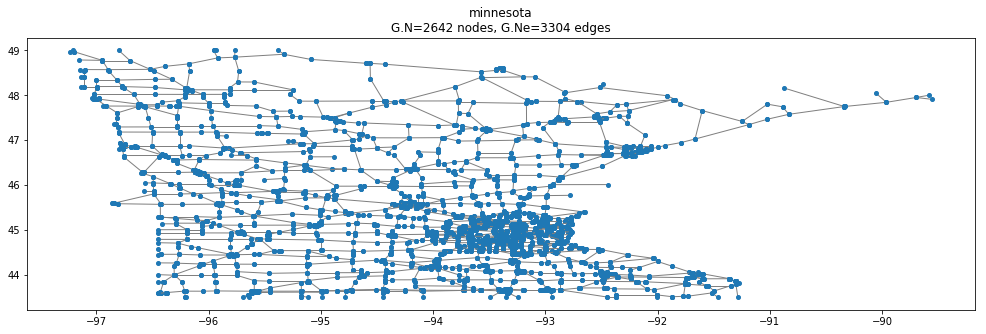

In [6]:
G.plot()

## 1.1 Custom graphs and properties

While the [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html) defines many graphs, we can easily use a custom graph by defining its adjacency matrix. The alternative is to provide features from which node similarities will be computed to form a sparse adjacency matrix (see `graphs.NNGraph`).

Let's create a random weighted adjacency matrix and look at some properties.

300 nodes, 6016 edges
Connected: True
Directed: False


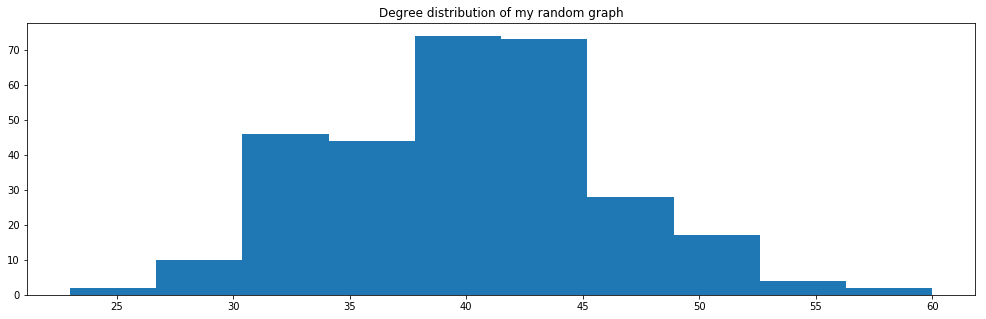

In [7]:
W = np.random.uniform(size=(300, 300))  # Full graph.
W[W < 0.93] = 0  # Sparse graph.
W = W + W.T  # Symmetric graph.
np.fill_diagonal(W, 0)  # No self-loops.

G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

print('Connected: {}'.format(G.is_connected()))
print('Directed: {}'.format(G.is_directed()))

plt.hist(G.d)
plt.title('Degree distribution of my random graph');

## 1.1 Exercise: layout

Coordinates are sometimes given, e.g. if the graph is a road network as above. If it's not the case, e.g. because we just have an adjacency matrix, we must assign coordinates before plotting in 2 or 3 dimension.

A [layout method](https://en.wikipedia.org/wiki/Graph_drawing) is an algorithm to embed a graph in 2D for the purpose of drawing.

Use the `set_coordinates` method to assign a 2D coordinate to each node of the below Barabasi-Albert graph. Use two strategies:
1. place the nodes on a ring with `ring2D` and
2. use a [force-directed layout](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) with `spring`.

In [ ]:
G = graphs.BarabasiAlbert(N=100)

fig, axes = plt.subplots(1, 2)

# Your code here.
G.plot(ax=axes[0])

# Your code here.
G.plot(ax=axes[1])

## 2 Laplacians

Let's create a community graph composed of `Nc=3` communities of 50, 120, and 80 nodes.

In [ ]:
communities = [50, 120, 80]
G = graphs.Community(N=250, Nc=3, comm_sizes=communities)

That graph is binary:

In [ ]:
print(np.unique(G.W.toarray()))

We can visualize it in two ways:
1. the sparsity pattern of its adjacency matrix `G.W` and
1. its node-link diagram.

Remember, visualizing data is often insightful!

In [ ]:
fig, axes = plt.subplots(1, 2)
_ = axes[0].spy(G.W, markersize=0.5)
G.set_coordinates('community2D')
G.plot(ax=axes[1])

We can use the combinatorial Laplacian $L = D - W$.

In [ ]:
G.compute_laplacian('combinatorial')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

Or the normalized Laplacian $L = I - D^{-1/2} W D^{-1/2}$.

In [ ]:
G.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

## 3 Graph signals

A graph signal $x: \mathcal{V} \rightarrow \mathbb{R}$ can be seen as a vector $x \in \mathbb{R}^N$, where $N = |\mathcal{V}|$ is the number of nodes.

Let's first create a random signal and visualize it on the graph.

In [ ]:
x = np.random.uniform(-1, 1, size=G.N)

In [ ]:
G.plot_signal(x)

### 3.1 Smoothness

Is it smooth? Our intuition certainly says no. Let's verify by computing $$x^T L x = \sum_{i \sim j} W_{ij} (x_i - x_j)^2$$

In [ ]:
x.T @ G.L @ x / np.linalg.norm(x)**2

Let's compare it with the partitioning function:
$$ x[i] =
\begin{cases}
    -1 &\text{if } i \in S_1, \\
    0  &\text{if } i \in S_2, \\
    1  &\text{if } i \in S_3,
\end{cases}
$$
where $S_i$ is the set of nodes in partition $i$.

In [ ]:
x = np.zeros(G.N)
x[:communities[0]] = -1 * np.ones(communities[0])
x[-communities[-1]:] = 1 * np.ones(communities[-1])

In [ ]:
G.plot_signal(x)

In [ ]:
x.T @ G.L @ x / np.linalg.norm(x)**2

That function is certainly smoother!

### 3.2 Exercise

What is the smoothest non-trivial signal?
$$\min_x x^T L x, \text{ s.t. } x \neq 0 \text{ and } x^T D^{1/2}1 = 0$$

In [ ]:
# Not the null signal.
x0 = np.zeros(G.N)
x0.T @ G.L @ x0

In [ ]:
# Not the "constant" signal either.
if G.lap_type == 'combinatorial':
    x1 = np.ones(G.N)
elif G.lap_type == 'normalized':
    x1 = np.power(G.d, 0.5) * np.ones(G.N)

x1.T @ G.L @ x1

In [ ]:
x = # Your code here.

print(x.T @ x1)
x.T @ G.L @ x / np.linalg.norm(x)**2

### 3.2 Gradient and divergence

## 4 Fourier basis

The PyGSP allows to compute the Fourier basis with the `compute_fourier_basis()` method. Remember that this involves the full eigendecomposition of the Laplacian which costs $\mathcal{O}(N^3)$ in general.

As expected, the GFT on a ring graph is equal to classical Fourier modes.

In [ ]:
G = graphs.Ring(N=50)
G.compute_fourier_basis()

fig, axes = plt.subplots(1, 2)
G.plot_signal(G.U[:, 4], ax=axes[0])

G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:4], ax=axes[1])

### 4.1 Exercise

Plot the first 7 Fourier modes of the grid and a sensor network. What do you observe?

**Your answer here.**

Hints:
* Use `G = graphs.Grid2d(10, 10)` and `G = graphs.Sensor(seed=42)`.

In [ ]:
# You code here.

### 4.2 Graph Fourier Transform

The graph Fourier transform (GFT) of a signal $x$ is given by
$$\hat{x} = U^T x,$$
where $U$ is the graph Fourier basis.

The inverse Fourier transform is given by
$$x = U \hat{x}.$$

The intuition about the smoothness of a signal and its representation in the spectral domain again transfers from classical Fourier analysis. Look a the below figures.

In [ ]:
G = graphs.Sensor(seed=42)
G.compute_fourier_basis()

taus = [0, 3, 10]
fig, axes = plt.subplots(len(taus), 2, figsize=(17, 9))

x0 = np.random.RandomState(1).normal(size=G.N)
for i, tau in enumerate(taus):
    g = filters.Heat(G, tau)
    x = g.filter(x0).squeeze()
    x_hat = G.gft(x).squeeze()
    
    G.plot_signal(x, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    axes[i, 0].text(0, -0.2, '$x^T L x = {:.2f}$'.format(x.T @ G.L @ x))
    
    axes[i, 1].plot(G.e, np.abs(x_hat), '.-')
    
axes[0, 0].set_title(r'$x$: signal in the vertex domain')
axes[0, 1].set_title(r'$\hat{x}$: signal in the spectral domain')
axes[-1, 1].set_xlabel("laplacian's eigenvalues / graph frequencies");

## 5 Filtering

A graph signal is filterd as
$$y = U g(\Lambda) U^T x = g(L) x,$$
where $g$ is the filter kernel.

In general, we try to avoid the need to compute the Fourier basis by defining filters as polynomials of the graph Laplacian. As long as you can specify your filter $g(\cdot)$ as a continuous function of the eigenvalues $\lambda$, the PyGSP will take care of computing the coefficients of the best approximating [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials).

In [ ]:
G1 = graphs.Sensor(seed=42)
G1.compute_fourier_basis()
G2 = graphs.Ring(N=100)
G2.compute_fourier_basis()
G2.set_coordinates('line1D')

TAUS = [0, 5, 100]
DELTA = 10

fig, axes = plt.subplots(len(TAUS), 3, figsize=(17, 7))

for i, tau in enumerate(TAUS):
    g1 = filters.Heat(G1, tau)
    g2 = filters.Heat(G2, tau)
    
    y = g1.localize(DELTA).squeeze()
    G1.plot_signal(y, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    axes[i, 0].text(0, -0.2, '$y^T L y = {:.2f}$'.format(y.T @ G1.L @ y))
    
    G2.plot_signal(g2.localize(G2.N//2), ax=axes[i, 2])
    axes[i, 2].set_title('')
    
    g1.plot(ax=axes[i, 1])
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
    text = r'$\hat{{g}}(\lambda) = \exp \left( \frac{{-{{{}}} \lambda}}{{\lambda_{{max}}}} \right)$'.format(tau)
    axes[i, 1].text(6, 0.5, text, fontsize=15)
    
axes[0, 0].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on sensor'.format(DELTA))
axes[0, 1].set_title('$\hat{g}(\lambda)$: filter defined in the spectral domain')
axes[0, 2].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on ring graph'.format(G2.N//2))
axes[-1, 1].set_xlabel("$\lambda$: laplacian's eigenvalues / graph frequencies");

### 5.1 Exercise

Look at the below code where we analyze a delta signal with two filter banks (`filters.MexicanHat` and `filters.Itersine`) and reconstruct it. How do you explain the difference in reconstruction error?

**Your answer here.**

Hints:
* Look at the filters in the spectral domain.

In [ ]:
G = graphs.Sensor(30, seed=42)
G.compute_fourier_basis()  # Reproducible computation of lmax.
s1 = np.zeros(G.N)
s1[13] = 1

In [ ]:
g = filters.MexicanHat(G, Nf=4)
s2 = g.analyze(s1)
s2 = g.synthesize(s2)
np.linalg.norm(s1 - s2)

In [ ]:
g = filters.Itersine(G, Nf=4)
s2 = g.analyze(s1)
s2 = g.synthesize(s2)
np.linalg.norm(s1 - s2)